# DSCI 100 - Report
### project-003-7: Nicole Campbell, Michelle Kim, Jason Liu, Zahra Raza

## Introduction

[WE NEED TO CHANGE THIS]
Our project is centered around factors that influence a student’s decision to pursue higher education based on academic performance. A student’s academic performance is often affected by different social and environmental factors. Thus, objective analysis on the relationship between those factors is critical to bolster maximum academic success. 
 
We will be working with the data set “Student Performance”, collected by Paulo Cortez at the University of Minho. The data set contains information gathered from students at two Portugese secondary students. The information collected includes student grades, social and study habits, and family background. The data set tracks first and second period grades as well as final grades in Portugese
 
We will try to answer the following question in this report:
Can we predict a student's study time, given Portuguese grades or math grades?

## Preliminary exploratory data analysis

In [1]:
### Run this cell before continuing. 
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column s

.pred_class,studytime,G1,G2,G3
<fct>,<fct>,<dbl>,<dbl>,<dbl>
2,2,11,13,13
2,2,13,12,13
2,3,10,12,13
⋮,⋮,⋮,⋮,⋮
2,2,8,9,9
1,2,6,9,11
1,1,10,11,11


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.39751553
kap,multiclass,0.01314376


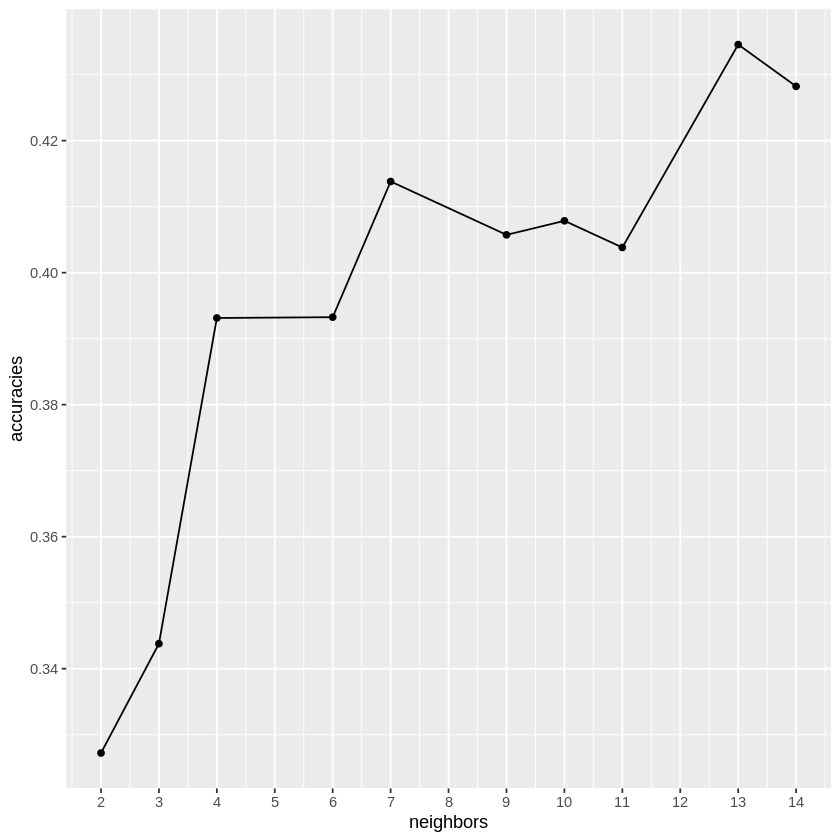

In [2]:
set.seed(2000);

#Read data set from the web into R
student_port <- read_delim("https://raw.githubusercontent.com/michelleykim/student_performance_analysis/main/data/student-por.csv", delim = ";") 
student_mat <- read_delim("https://raw.githubusercontent.com/michelleykim/student_performance_analysis/main/data/student-mat.csv", delim = ";")

# Clean and wrangle data into tidy format
port_select <- student_port %>%
                select("studytime", "G1", "G2", "G3") %>%
                mutate(studytime = as_factor(studytime))
mat_select <- student_mat %>%
                select("studytime", "G1", "G2", "G3") %>%
                mutate(studytime = as_factor(studytime))

# Obtain training set:
# We chose strata = 0.75 since the data set is small enough that we will still 
# have a reasonable amount of training and testing data with this split.
port_split <- initial_split(port_select, prop = 0.75, strata = studytime) 
port_train <- training(port_split)
port_test <- testing(port_split)

mat_split <- initial_split(mat_select, prop = 0.75, strata = studytime) 
mat_train <- training(mat_split)
mat_test <- testing(mat_split)

# vfold_cv
port_vfold <- vfold_cv(port_train, v = 5, strata = studytime)

# recipe
port_recipe <- recipe(studytime ~., data = port_train) %>%
        step_scale(all_predictors()) %>%
        step_center(all_predictors())

# nearest_neighbour
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
        set_engine("kknn") %>%
        set_mode("classification")

# workflow & tune_grid
knn_workflow <- workflow() %>%
        add_recipe(port_recipe) %>%
        add_model(knn_spec) %>%
        tune_grid(resamples = port_vfold, grid = 10) %>%
        collect_metrics()

# choose k value, graph k = 5
accuracies <- knn_workflow %>%
        filter(.metric == "accuracy")
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "neighbors", y = "accuracies") +
        scale_x_continuous(breaks = seq(0, 14, by = 1))

# nearest_neighbour with k, workflow 
port_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>%
        set_engine("kknn") %>%
        set_mode("classification")

port_fit <- workflow() %>%
        add_recipe(port_recipe) %>%
        add_model(port_spec) %>%
        fit(data = port_train)

# predict
port_predictions <- predict(port_fit, port_test) %>%
        bind_cols(port_test)

# maybe do metrics, conf_mat
port_metrics <- port_predictions %>%
        metrics(truth = studytime, estimate = .pred_class)
port_conf_mat <- port_predictions %>%
        conf_mat(truth = studytime, estimate = .pred_class)

# print
cross_val_plot
port_predictions
port_metrics

In [4]:
# number of observations in higher(target variable)
counts <- port_train %>%
        group_by(studytime) %>%
        summarize(n=n())   
counts

# average grade of term 1, term 2, and final Portuguese grade
ave_grade <- port_train %>%
            summarize(G1 = mean(G1), G2 = mean(G2), G3 = mean(G3))
ave_grade

`summarise()` ungrouping output (override with `.groups` argument)



studytime,n
<fct>,<int>
1,158
2,228
3,73
4,29


G1,G2,G3
<dbl>,<dbl>,<dbl>
11.41803,11.57787,11.8668


## Citation:
P. Cortez and A. Silva. Using Data Mining to Predict Secondary School Student Performance. In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7. https://archive.ics.uci.edu/ml/datasets/Student+Performance#
